导入库

In [1]:
import pandas as pd
import numpy as np 
import re 
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from sklearn.compose import ColumnTransformer
import urlextract
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier,SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

第一步：读取文件

In [2]:
train = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
train.columns = ["Sentiment", "time", "date", "query", "username", "Tweet_content"]

第二步：将文件中Sentiment列的4和0改为'Positive'和'Negative'（ps：不知道为什么，不改的话后面拆分会出bug读不出来分类）
（由于数据集中的数据量过大，因此本模型中只选取每种情绪中的前两万个数据，共四万数据，同时也保证了样本量的均衡）

In [3]:
data_pos = train[train['Sentiment'] == 4]
data_neg = train[train['Sentiment'] == 0]
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]
train = pd.concat([data_pos, data_neg])
train.loc[train['Sentiment'] == 4, 'Sentiment'] = 'Positive'
train.loc[train['Sentiment'] == 0, 'Sentiment'] = 'Negative'

词云图

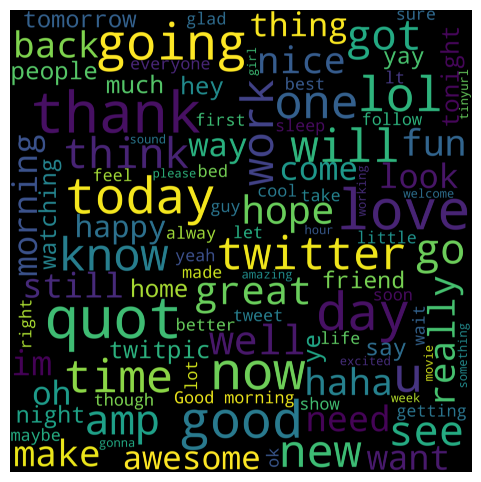

In [4]:
word_cloud_text = ''.join(train[train["Sentiment"]=="Positive"].Tweet_content)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

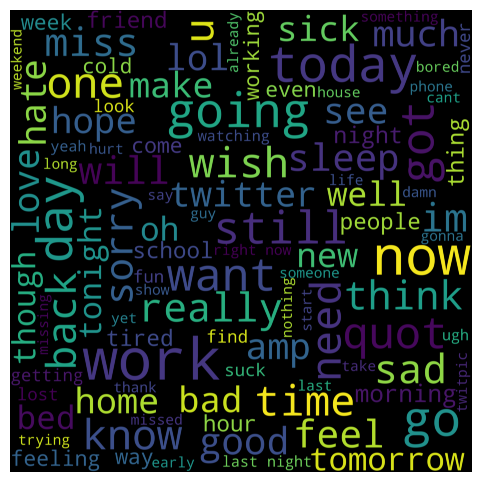

In [5]:
word_cloud_text_negative = ''.join(train[train["Sentiment"]=="Negative"].Tweet_content)
wordcloud_negative = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text_negative)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.show()

第三步：EDA处理，即对文字进行预处理  （下面包括定义的各种预处理函数）

尝试使用过下面的代码去除URLs连接，但是比起正则的方法来说运行速度太慢了：

def remove_urls(text):

    """Removes URLs from the given text"""
    extractor = urlextract.URLExtract()
    urls = extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, "")
    return text

In [6]:
#使用正则的方法来去除文字内容中的URL链接
#参考文献：https://www.w3schools.com/python/python_regex.asp(介绍正则相关内容的)
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    result = url_pattern.sub(r'', text)
    return result

#使用正则的方式去除文字内容中的emoji
#参考文献：https://unicode.org/emoji/charts/emoji-versions.html(介绍emoji相关内容的，可以找到 Emoji 表情符号的代码点范围)
def remove_emojis(text):
    """Removes emojis from the given text"""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251"  # enclosed characters
                               "]+", flags=re.UNICODE)
    result = emoji_pattern.sub(r'', text)
    return result

In [7]:
train['Tweet_content'] = train['Tweet_content'].apply(remove_urls)
train['Tweet_content'] = train['Tweet_content'].apply(remove_emojis)
train['text_lens']=train['Tweet_content'].apply(len)

处理完后去除数据中的缺失值和重复值。

In [8]:
train.dropna(inplace=True)
train.drop_duplicates(inplace=True)

In [9]:
#去除'train'数据集中指定列（'text_lens'列）中的异常值（outliers）。
#异常值是指与其他样本明显不同或偏离正常分布的数据点，其存在可能会对数据分析和模型训练产生不良影响。
#整个过程可以理解为在箱线图中去除超出上下限的数据点，使得数据集更加接近正常分布。
#这有助于减少异常值对数据分析和模型训练的影响，提高模型的鲁棒性和准确性。
#参考文献：可以搜索关于"outlier detection"或"outlier removal"的相关文献
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#remove outliers
train = remove_outlier(train,'text_lens')

标记化和词表化：

对DataFrame train 中的 'Tweet_content' 列进行文本预处理，并将预处理后的结果存储在新的 'preprocessed_text' 列中。

下面这段代码将对 'Tweet_content' 列中的每个文本样本进行分词、词性标注、词干提取，并去除停用词和标点符号，最终将预处理后的文本存储在 'preprocessed_text' 列中。这些预处理操作可以减少文本中的噪声，使得后续的文本分析和建模任务更加有效和准确。

唯一的问题就是运行时间较长，大概要10分钟

In [10]:
#参考文献：SpaCy文档: https://spacy.io/
#可以在相关的自然语言处理教程和SpaCy文档中找到相关的资料和例子
nlp=spacy.load('en_core_web_sm')
def preprocess(text):
    doc = nlp(text)
    filtered_tokens=[]
    for token in doc:
        if not token.is_stop and not token.is_punct:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)
    

train['preprocessed_text']=train['Tweet_content'].apply(preprocess)

第四步：拆分成训练集和测试集

In [11]:
X_train ,X_test , y_train, y_test = train_test_split(train[['preprocessed_text']],train[['Sentiment']],test_size=0.2,random_state=42,stratify=train[['Sentiment']])

第五步：将原始的文本数据转换为TF-IDF特征矩阵

来源于chatgpt的解释：

在这个过程中，TfidfVectorizer会计算每个词的TF-IDF值，这是一种用于衡量一个词在文档中的重要性的度量。TF-IDF值越高，表示词在当前文本中越重要，但同时考虑了该词在整个语料库中的频率。

结果是，我们获得了一个稀疏矩阵，其中的每一行代表一个文本数据样本，每一列代表一个词语，并且值表示对应词语的TF-IDF值。

这样的转换将文本数据转换为数值特征，使得我们可以将其输入到机器学习模型中进行分类或其他任务的训练和预测。

In [12]:
#参考文献：scikit-learn官方文档：https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
#NLTK官方文档：https://www.nltk.org/
#Tfidf（Term Frequency-Inverse Document Frequency）的原理和概念
y_train = y_train['Sentiment'].map({"Positive": 0, "Negative": 1})
y_test = y_test['Sentiment'].map({"Positive": 0, "Negative": 1})

vectorizer= TfidfVectorizer()

X_train_vect= vectorizer.fit_transform(X_train['preprocessed_text'])
X_test_vect= vectorizer.transform(X_test['preprocessed_text'])


第六步：使用机器学习方法中的随机森林方法进行训练，这个也要大概10分钟

In [13]:
model = RandomForestClassifier()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      4000
           1       0.72      0.73      0.72      4000

    accuracy                           0.72      8000
   macro avg       0.72      0.72      0.72      8000
weighted avg       0.72      0.72      0.72      8000



第七步：使用机器学习方法中的MultinomialNB方法，这个方法运行的很快

In [14]:
model = MultinomialNB()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      4000
           1       0.71      0.77      0.74      4000

    accuracy                           0.72      8000
   macro avg       0.73      0.72      0.72      8000
weighted avg       0.73      0.72      0.72      8000

